In [ ]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/mnt/c/MyPrograms/__github/Stabilized_ICA')
print(sys.path)


In [12]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from algorithms.stabilized_ICA import StabilizedICA
import anndata
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]


def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled


def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

def preprocessing_without_pooling(adata):
    if Normalize_Totals:
        med = np.median(adata.obs['total_counts'])
        #med = 10000
        print('Normalizing to the number of counts = ',med)
        sc.pp.normalize_total(adata, target_sum=med)
    if not Already_Log_Transformed:
        print('Taking log...')
        sc.pp.log1p(adata,base=10)
    if top_variable_genes>0:
        print('Selecting genes:',top_variable_genes)
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata,adata_orig):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        preprocessing_without_pooling(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def preprocessing_dataset(adata):
    adata = preprocessing_without_pooling(adata)    
    sc.tl.pca(adata,n_comps=number_of_pcs)
    display(adata)
    return adata

def calc_weighted_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names_weights = signature_dict[key]
        names = names_weights[0]
        weights = np.array(names_weights[1])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        sel_names = anndata.var_names[inds]
        ind_in_names = ismember(sel_names,names)
        names1 = np.array(names)[ind_in_names]
        weights1 = np.array(weights)[ind_in_names]
        inds = ismember(names1,anndata.var_names)
        matrix_sel = matrix[:,inds]
        gene_means = np.mean(matrix_sel,axis=0)
        meanmat = np.outer(np.ones(matrix_sel.shape[0]),gene_means)
        matrix_sel = matrix_sel-meanmat
        scores = np.matmul(matrix_sel,weights1)
        scores_dic[key] = scores
    return scores_dic

def load_weighted_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst1 = [s.split('[')[0] for s in lst if not s=='']
            weights = [float(s.split('[')[1].split(']')[0]) for s in lst if not s=='']
            #print(lst1,weights)
            sigs[parts[0]] = (lst1,weights)
            #sigs[parts[0]+'_W'] = weights
            line = fin.readline().strip('\n').strip(' ')
    return sigs




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#folder = '../Broad_CellLine/'
#cell_line = 'JHU011_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'TE14_OESOPHAGUS'
#cell_line = 'CAMA1_BREAST'
#cell_line = 'SCC47_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'SCC9_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'OVTOKO_OVARY'
#cell_line = 'ABC1_LUNG'
##cell_line = 'SCC25_UPPER_AERODIGESTIVE_TRACT'
#suffix = '_raw'
#Normalize_Totals = False
#division_factor = 50

#folder = '../Retinoblastoma/Y79/'
#cell_line = 'Y79'
#suffix = ''
#division_factor = 1
#Normalize_Totals = True

#folder = '/mnt/c/Datas/BIODICA_GUI/work/Y79_nufp10k_ICA/'
#cell_line = 'Y79_nufp10k'
#suffix = ''

folder = '../EwingSarcoma_Miller2020/CHLA9/'
cell_line = 'CHLA9'
division_factor = 1
suffix = ''
Normalize_Totals = True

#folder = '../EwingSarcoma_Miller2020/CHLA10/'
#cell_line = 'CHLA10'
#division_factor = 1
#suffix = ''
#Normalize_Totals = True

In [ ]:
# This cell is specific to Broad cell line collection
# It extracts a cell line from the large CPM_data.txt file
# This step can be done only once and will create a cell_line+'_raw.txt' 
# file containing the CPM counts that need to be pre-processed in the next cell

# Extracting the cell line data

metadata = pd.read_csv(folder+'metadata_header.txt',delimiter='\t')
display(metadata)
cancer_types = list(metadata['Cancer_type'])
cell_lines = list(metadata['Cell_line'])
cellnames = list(metadata['NAME'])

ind_cell_line = np.where(np.array(cell_lines)==cell_line)[0]
with open(folder+'CPM_data.txt') as fin, open(folder+cell_line+'_raw.txt','w') as fout:
    header = fin.readline()[:-1]
    cells = np.array(header.split('\t'))
    ind_cells = [0]+list(ind_cell_line+1)
    fout.write('\t'.join(cells[ind_cells])+'\n')
    ln = fin.readline()[:-1]
    while ln:
        cells = ln.split('\t')
        selected_vals = np.array(cells)[ind_cells[1:]]
        selected_vals = [str(int(float(s))) for s in selected_vals]
        fout.write(cells[0]+'\t'+'\t'.join(selected_vals)+'\n')
        ln = fin.readline()[:-1]

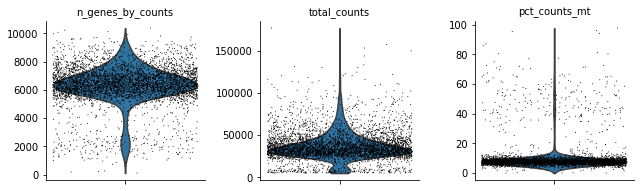

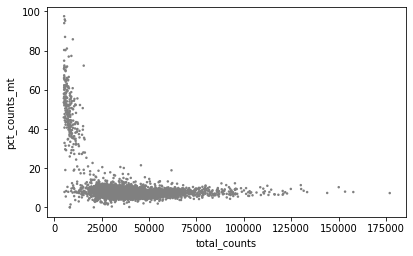

3862 samples pass the count filter
4159  samples pass the mt filter
Samples selected 3460
top_variable_genes taken for pooling: 10000


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Normalizing to the number of counts =  32994.5


/home/zinovyev/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Taking log...
Selecting genes: 10000
Normalizing to the number of counts =  32994.5
Taking log...
Selecting genes: 10000


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 3460 × 10000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [15]:
# Preprocessing the file
# It is normally should be done only once and result in cell_line+'_proc.txt' 
# file. Pay attention that you might want to change the dataset-specific 
# thresholds on the total counts and mt percentage.
# If this is already done then one can open the "_proc.txt" file right away 
# in the next cell

top_variable_genes = 10000 # if negative then no selection of genes
#Normalize_Totals = True
Already_Log_Transformed = False
n_neighbours_for_pooling = 5
number_of_pcs = 20


df = pd.read_csv(folder+cell_line+suffix+'.txt',delimiter='\t')
adata_k = sc.AnnData(X=df[df.columns[1:]].to_numpy().transpose())
adata_k.obs_names = list(df.columns[1:])
adata_k.var_names = list(df[df.columns[0]])
adata_k.X = adata_k.X/division_factor
adata_k.var_names_make_unique()

# Quality control
adata_k.var['mt'] = adata_k.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_k, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_k, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_k, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata_k.obs['total_counts']>10000) & (adata_k.obs['total_counts']<50000))
inds2 = np.where(adata_k.obs['pct_counts_mt']<10)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))
adata_k = adata_k[ind_samples,:]


if n_neighbours_for_pooling>0:
    #temp_top_variable_genes = top_variable_genes
    #adata_k_temp = adata_k.copy()
    #top_variable_genes = -1
    #adata_k_temp = preprocessing_without_pooling(adata_k_temp)
    #top_variable_genes = np.sum(np.var(adata_k_temp.X,axis=0)>0.01)
    #top_variable_genes = 5000
    print('top_variable_genes taken for pooling:',top_variable_genes)
    adata_k1 = pooling_procedure(adata_k,adata_k)
    #top_variable_genes = temp_top_variable_genes
    adata_k1 = preprocessing_dataset(adata_k1)
else:
    adata_k1 = preprocessing_dataset(adata_k)
dc = {'GENE':list(adata_k1.var_names)}
for j,s in enumerate(adata_k1.obs_names):
    dc[s] = adata_k1.X[j,:]
pd.DataFrame(data=dc).to_csv(folder+cell_line+'_proc.txt',sep='\t',index=False)

In [5]:
#file = folder+cell_line+'.txt'
#df = pd.read_csv(file , sep='\t', index_col=0)
#df = df.transpose()
#display(df)

In [16]:
file = folder+cell_line+'_proc.txt'
df = pd.read_csv(file , sep='\t', index_col=0)
df = df.transpose()
display(df)

GENE,HIST1H4C,HIST1H1B,ASPM,CCNB1,HIST1H1D,CDC20,TOP2A,DLGAP5,CENPE,UBE2C,...,ANP32A,BTN3A2,AL391807.1,CIB2,AC026333.4,KIAA0391,ZNF230,C11orf58,LSR,CYTH3
AAACCCAGTTGTACGT-1,0.862712,0.156481,0.361978,0.156481,0.318989,0.156481,0.556623,0.085251,0.000000,0.217659,...,1.048975,0.000000,0.085251,0.085251,0.085251,0.000000,0.000000,1.178911,0.085251,0.085251
AAACGAAAGACCCGCT-1,0.354797,0.000000,1.375563,1.408916,0.083000,1.343600,1.553259,1.106988,1.191206,1.002412,...,1.121055,0.083000,0.000000,0.000000,0.000000,0.000000,0.083000,1.202826,0.000000,0.083000
AAACGAAGTGGCTAGA-1,1.954379,0.762165,1.483878,1.335970,0.477966,1.154406,1.680388,1.186093,1.254608,1.357089,...,1.023923,0.000000,0.062317,0.116804,0.000000,0.116804,0.000000,1.054528,0.116804,0.000000
AAACGAATCGAATCCA-1,2.140670,1.171716,1.336393,0.958656,1.033572,0.776675,1.635196,0.868066,0.877128,0.776675,...,1.097446,0.062813,0.166383,0.000000,0.000000,0.000000,0.000000,1.086509,0.062813,0.117678
AAACGCTGTAGTACGG-1,0.832681,0.000000,1.152476,1.391128,0.000000,1.287993,1.365681,1.086545,1.008782,0.662915,...,1.057089,0.079215,0.000000,0.000000,0.146186,0.000000,0.079215,1.182032,0.146186,0.204196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCATCACCC-1,0.596730,0.000000,0.355030,0.152778,0.083073,0.083073,0.547726,0.083073,0.265573,0.265573,...,1.046043,0.083073,0.083073,0.000000,0.000000,0.083073,0.000000,1.128310,0.000000,0.000000
TTTGGTTTCCAAGCTA-1,1.991856,1.176209,1.059137,0.469812,1.210718,0.314626,1.304163,0.495156,0.495156,0.541796,...,1.016830,0.070875,0.131790,0.275619,0.000000,0.070875,0.070875,1.155184,0.000000,0.000000
TTTGGTTTCGTGGGTC-1,2.148297,0.960627,1.330676,1.085052,1.061657,0.960627,1.698615,0.975535,1.036929,0.937260,...,1.049469,0.064262,0.064262,0.064262,0.000000,0.064262,0.000000,1.101808,0.120229,0.000000
TTTGTTGAGAACGCGT-1,1.529217,0.498635,0.459891,0.186981,0.567078,0.417350,0.944595,0.103477,0.417350,0.256990,...,1.028798,0.000000,0.103477,0.103477,0.103477,0.000000,0.186981,1.080295,0.000000,0.000000


(10000,)
running time (min): 00:37.03


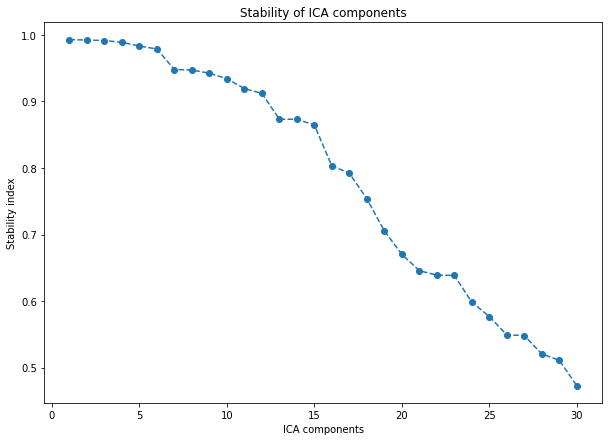

In [17]:
start = time.time()

X = df.values
#Uncomment next line if you want to subsample the dataset
#X = X[np.random.choice(X.shape[0],1000),:]
mn = np.mean(X,axis=0)
print(mn.shape)
X = X - mn


sICA = StabilizedICA(n_components = 30 , max_iter = 2000, n_jobs = -1)
sICA.fit(X, n_runs = 100, plot = True, normalize=True, fun='logcosh')

end = time.time()

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

In [18]:
Metagenes = pd.DataFrame(sICA.S_ , columns = df.columns , index = ['IC'+ str(i+1) for i in range(sICA.S_.shape[0])])
display(Metagenes)
sfile = file[:-4]+"_PT_S.xls"
Metagenes.transpose().to_csv(sfile,sep='\t')

#sfile = 'Y79_nufp10k_ica_S.xls'
#sfile = '/mnt/c/Datas/BIODICA_GUI/work/CHLA9_nufp10k_ICA/CHLA9_nufp10k_ica_S.xls'
#sfile = '/mnt/c/Datas/BIODICA_GUI/work/CHLA9_proc_ICA/CHLA9_proc_ica_S.xls'
#temp = pd.read_csv(sfile,delimiter='\t',index_col=False).transpose()
#Xtemp = temp.to_numpy()[1:-1,:]
#Metagenes = pd.DataFrame(Xtemp, columns = list(temp.to_numpy()[0,:]), index = ['IC'+ str(i+1) for i in range(Xtemp.shape[0])])
#display(Metagenes)

GENE,HIST1H4C,HIST1H1B,ASPM,CCNB1,HIST1H1D,CDC20,TOP2A,DLGAP5,CENPE,UBE2C,...,ANP32A,BTN3A2,AL391807.1,CIB2,AC026333.4,KIAA0391,ZNF230,C11orf58,LSR,CYTH3
IC1,0.078229,0.320504,-0.332735,-0.061353,1.015030,0.191981,0.316814,0.800677,-0.001189,0.755244,...,-0.286881,-0.407726,0.332324,0.376383,-0.046656,0.013824,-0.520313,-0.257324,0.247908,-0.000816
IC2,2.104597,0.685200,3.602785,-3.533219,0.275625,-2.315234,-1.868245,-2.933715,-2.603119,-2.163397,...,0.705355,0.007637,-0.486632,-0.601312,0.466230,-0.127389,-0.041833,-0.234016,0.258322,-0.013732
IC3,-1.380330,-0.843313,0.794683,-0.256579,0.975573,-2.535065,-0.769616,-1.447650,0.044318,0.246360,...,0.684016,0.262555,-0.782091,0.054780,-0.092635,0.594583,0.159307,-0.394808,0.014166,0.119967
IC4,26.174461,24.129685,-0.823644,-4.510025,21.986233,-4.547210,5.191219,-0.392543,-2.079414,-1.141589,...,-0.431319,-0.149494,0.515241,1.183581,-0.222389,-0.251931,0.286632,-0.020610,0.045731,-0.396388
IC5,0.941074,1.246142,1.325372,-0.868657,0.427036,-0.383182,-2.265812,0.529212,0.790698,-0.351336,...,0.895212,-0.808210,-0.649963,0.450461,0.014714,0.214386,-0.052154,0.101449,0.757613,0.020010
IC6,-3.226853,0.806608,0.894834,0.665628,0.463628,0.965125,0.650007,2.894708,1.414094,-2.985355,...,1.742635,-0.554963,-0.315765,-0.250271,-0.810742,-0.058608,-0.465294,0.285404,-0.044837,0.078884
IC7,-0.088967,0.561653,1.175046,0.730946,-0.396484,-1.566611,-0.745851,0.040923,0.024496,-0.046078,...,-2.053046,-0.583853,0.352518,-0.804698,-0.176533,-0.208223,0.178014,-0.168440,0.157257,-0.131659
IC8,-0.415401,-0.011185,-0.143470,-0.153527,-0.275126,0.324244,1.234920,-0.682503,0.968444,0.453133,...,-0.329315,-0.115652,0.453538,-0.080429,0.800314,-0.027335,-0.502321,0.396917,-0.161057,-0.990442
IC9,1.894198,0.448768,-0.062921,-0.242435,-0.209630,0.027602,0.019961,0.693740,-0.592555,-1.766783,...,-0.824348,-0.384235,0.869863,-0.374881,-0.697116,-0.161077,-0.737773,0.391279,0.433086,-0.015361
IC10,12.497823,3.065166,0.435988,-0.473856,1.531290,0.043991,-1.670358,1.486006,0.044732,-1.991458,...,-0.415615,-0.296690,1.237127,-0.807616,-0.008129,0.176577,-0.512227,-0.839427,0.241581,-0.358477


G2M -> IC11 ( 7.748143963531816 )
G2M_INH -> IC15 ( 4.100993440908163 )
G1S -> IC2 ( 8.580733642998597 )
HISTONES -> IC4 ( 17.009672401901014 )


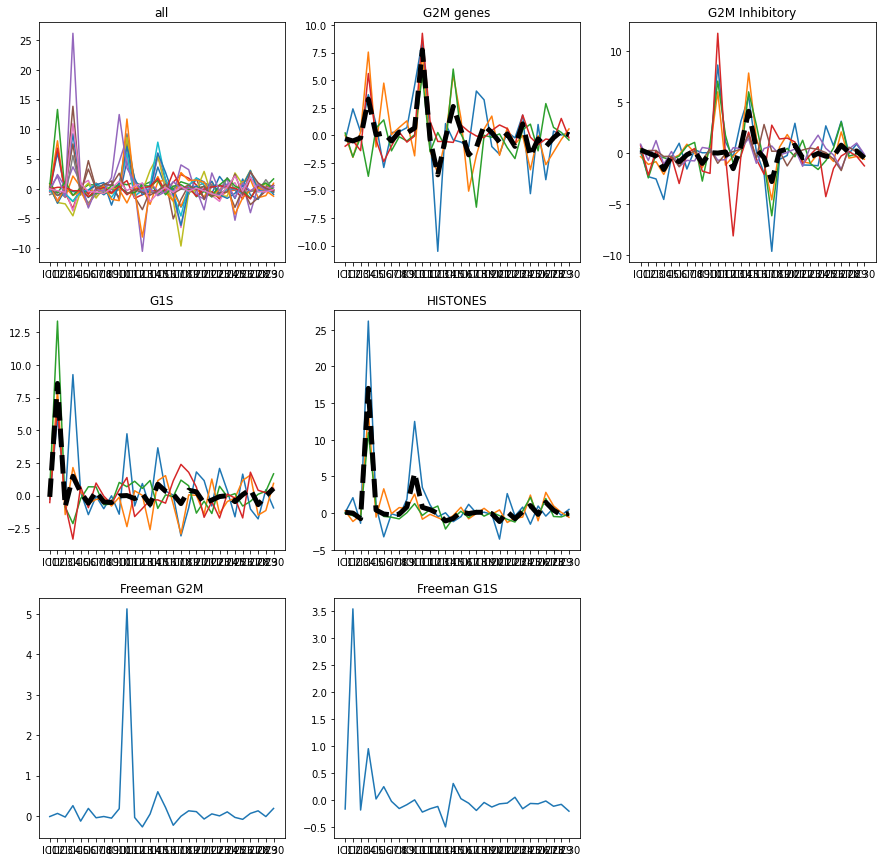

In [19]:
freeman_G1S = ['ADAMTS1','ASF1B','ATAD2','BARD1','BLM','BRCA1','BRIP1','C17orf75','C9orf40','CACYBP','CASP8AP2','CCDC15','CCNE1','CCNE2','CCP110','CDC25A','CDC45','CDC6','CDC7','CDK2','CDT1','CENPJ','CENPQ','CENPU','CEP57','CHAF1A','CHAF1B','CHEK1','CLSPN','CREBZF','CRYL1','CSE1L','DCLRE1B','DCTPP1','DEK','DERA','DHFR','DNA2','DNAJC9','DNMT1','DONSON','DSCC1','DSN1','DTL','E2F8','EED','EFCAB11','ENDOD1','ETAA1','EXO1','EYA2','EZH2','FAM111A','FANCE','FANCG','FANCI','FANCL','FBXO5','FEN1','GGH','GINS1','GINS2','GINS3','GLMN','GMNN','GMPS','GPD2','HADH','HELLS','HSF2','ITGB3BP','KIAA0101','KNTC1','LIG1','MCM10','MCM2','MCM3','MCM4','MCM5','MCM6','MCM7','MCMBP','METTL9','MMD','MNS1','MPP1','MRE11A','MSH2','MSH6','MYO19','NASP','NPAT','NSMCE4A','ORC1','OSGEPL1','PAK1','PAQR4','PARP2','PASK','PAXIP1','PBX3','PCNA','PKMYT1','PMS1','POLA1','POLA2','POLD3','POLE2','PRIM1','PRPS2','PSMC3IP','RAB23','RAD51','RAD51AP1','RAD54L','RBBP8','RBL1','RDX','RFC2','RFC3','RFC4','RMI1','RNASEH2A','RPA1','RRM1','RRM2','SLBP','SLC25A40','SMC2','SMC3','SSX2IP','SUPT16H','TEX30','TFDP1','THAP10','THEM6','TIMELESS','TIPIN','TMEM106C','TMEM38B','TRIM45','TRIP13','TSPYL4','TTI1','TUBGCP5','TYMS','UBR7','UNG','USP1','WDHD1','WDR76','WRB','YEATS4','ZBTB14','ZWINT']
freeman_G2M = ['ADGRE5','ARHGAP11A','ARHGDIB','ARL6IP1','ASPM','AURKA','AURKB','BIRC5','BORA','BRD8','BUB1','BUB1B','BUB3','CCNA2','CCNB1','CCNB2','CCNF','CDC20','CDC25B','CDC25C','CDC27','CDCA3','CDCA8','CDK1','CDKN1B','CDKN3','CENPE','CENPF','CENPI','CENPN','CEP55','CEP70','CEP85','CKAP2','CKAP5','CKS1B','CKS2','CTCF','DBF4','DBF4B','DCAF7','DEPDC1','DLGAP5','ECT2','ERCC6L','ESPL1','FAM64A','FOXM1','FZD2','FZD7','FZR1','GPSM2','GTF2E1','GTSE1','H2AFX','HJURP','HMGB2','HMGB3','HMMR','HN1','INCENP','JADE2','KIF11','KIF14','KIF15','KIF18A','KIF18B','KIF20A','KIF20B','KIF22','KIF23','KIF2C','KIF4A','KIF5B','KIFC1','KPNA2','LBR','LMNB2','MAD2L1','MELK','MET','METTL4','MIS18BP1','MKI67','MPHOSPH9','MTMR6','NCAPD2','NCAPG','NCAPG2','NCAPH','NDC1','NDC80','NDE1','NEIL3','NEK2','NRF1','NUSAP1','OIP5','PAFAH2','PARPBP','PBK','PLEKHG3','PLK1','PLK4','PRC1','PRR11','PSRC1','PTTG1','PTTG3P','RACGAP1','RAD21','RASSF1','REEP4','SAP30','SHCBP1','SKA1','SLCO1B3','SOGA1','SPA17','SPAG5','SPC25','SPDL1','STIL','STK17B','TACC3','TAF5','TBC1D2','TBC1D31','TMPO','TOP2A','TPX2','TROAP','TTF2','TTK','TUBB4B','TUBD1','UBE2C','UBE2S','VANGL1','WEE1','WHSC1','XPO1','ZMYM1']
g2m_markers = ['CDK1','MKI67','CCNB2','AURKB']
g1s_markers = ['RRM2','PCNA','MCM10','ORC6']
g2m_inhibitory_markers = ['CDC20','CDKN3','UBE2S','UBE2C','UBB','PSMA7','PSMB2']
histone_markers = ['HIST1H4C','HIST1H1E','HIST2H2AC']

freeman_G1S = [s for s in freeman_G1S if s in Metagenes]
freeman_G2M = [s for s in freeman_G2M if s in Metagenes]
g2m_markers = [s for s in g2m_markers if s in Metagenes]
g1s_markers = [s for s in g1s_markers if s in Metagenes]
g2m_inhibitory_markers = [s for s in g2m_inhibitory_markers if s in Metagenes]
histone_markers = [s for s in histone_markers if s in Metagenes]

g2m_score = np.mean(Metagenes[g2m_markers],axis=1)
g1s_score = np.mean(Metagenes[g1s_markers],axis=1)
g2m_inhibitory_score = np.mean(Metagenes[g2m_inhibitory_markers],axis=1)
histone_score = np.mean(Metagenes[histone_markers],axis=1)

idx_g2m_signal = np.argmax(g2m_score)
g2m_inhibitory_score[idx_g2m_signal] = 0
g1s_score[idx_g2m_signal] = 0
idx_g1s_signal = np.argmax(g1s_score)
histone_score[idx_g1s_signal] = 0
g2m_inhibitory_score[idx_g1s_signal] = 0
idx_g2m_inhibitory_signal = np.argmax(g2m_inhibitory_score)
idx_histone_signal = np.argmax(histone_score)

print('G2M ->','IC'+str(idx_g2m_signal+1),'(',g2m_score[idx_g2m_signal],')')
print('G2M_INH ->','IC'+str(idx_g2m_inhibitory_signal+1),'(',g2m_inhibitory_score[idx_g2m_inhibitory_signal],')')
print('G1S ->','IC'+str(idx_g1s_signal+1),'(',g1s_score[idx_g1s_signal],')')
print('HISTONES ->','IC'+str(idx_histone_signal+1),'(',histone_score[idx_histone_signal],')')

fig = plt.figure(figsize=(15,15))

plt.subplot(3,3,1)
plt.plot(Metagenes[g1s_markers+g2m_markers+g2m_inhibitory_markers+histone_markers])
plt.title('all')

plt.subplot(3,3,2)
plt.plot(Metagenes[g2m_markers])
plt.plot(g2m_score,'k--',linewidth=5)
plt.title('G2M genes')

plt.subplot(3,3,3)
plt.plot(Metagenes[g2m_inhibitory_markers])
plt.plot(g2m_inhibitory_score,'k--',linewidth=5)
plt.title('G2M Inhibitory')

plt.subplot(3,3,4)
plt.plot(Metagenes[g1s_markers])
plt.plot(g1s_score,'k--',linewidth=5)
plt.title('G1S')

plt.subplot(3,3,5)
plt.plot(Metagenes[histone_markers])
plt.plot(histone_score,'k--',linewidth=5)
plt.title('HISTONES')

plt.subplot(3,3,7)
plt.plot(np.mean(Metagenes[freeman_G2M],axis=1))
plt.title('Freeman G2M')

plt.subplot(3,3,8)
plt.plot(np.mean(Metagenes[freeman_G1S],axis=1))
plt.title('Freeman G1S')
plt.show()

/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


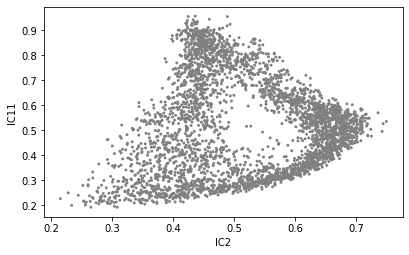

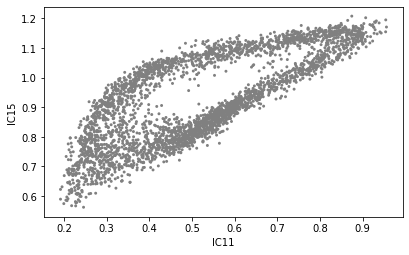

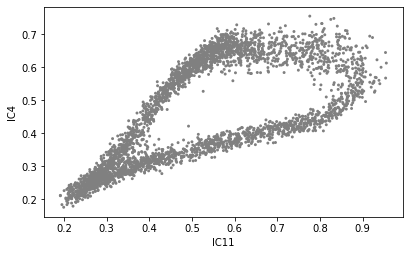

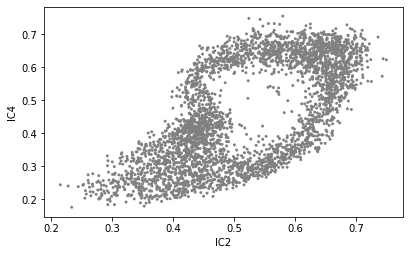

In [20]:
gmtfile = sfile[:-4]+'.gmt'

threshold = 3
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:]]
with open(gmtfile,'w') as fout:
    for s in dfs1.columns:
        fout.write(s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if val>threshold:
                fout.write(gn+'\t')
        fout.write('\n')
        
threshold = 2
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:]]
gmtfile_weighted = sfile[:-4]+'_weighted.gmt'
with open(gmtfile_weighted,'w') as fout:
    for s in dfs1.columns:
        fout.write(s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if abs(val)>threshold:
                fout.write(gn+'['+str(val)+']'+'\t')
        fout.write('\n')

signature_dict = load_signature_file(gmtfile)

adata = sc.AnnData(X=df.to_numpy())
adata.var_names = list(df.columns)
adata.obs_names = list(df.index)

sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]
scores_dic = calc_scores(adata2k,signature_dict)
#scores_dic = calc_weighted_scores(adata2k,signature_dict)
for s in scores_dic:
    adata.obs[s] = scores_dic[s]

sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC'+str(idx_g2m_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g2m_signal+1),y='IC'+str(idx_g2m_inhibitory_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g2m_signal+1),y='IC'+str(idx_histone_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC'+str(idx_histone_signal+1))

In [165]:
#sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC24')
#sc.pl.scatter(adata,x='IC'+str(idx_g2m_inhibitory_signal+1),y='IC14')

Text(0.5, 1.0, 'G2M Inhibitory')

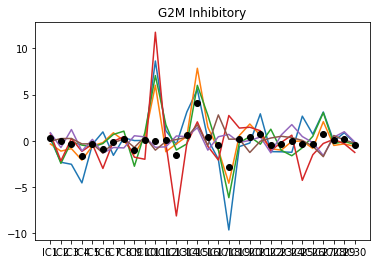

In [21]:
plt.plot(Metagenes[g2m_inhibitory_markers])
plt.plot(g2m_inhibitory_score,'ko',linewidth=5)
plt.title('G2M Inhibitory')


In [393]:
import os
from os import listdir
from os.path import isfile, join

# Batch decomposition of multiple cell lines
folder_batch = '../Broad_CellLine/cell_lines/'
files = [f for f in listdir(folder_batch) if (isfile(join(folder_batch, f)))&('_proc' in f)&(f.endswith('.txt'))]
#print(files)
#if False:
i=1
for file in files:
    sfile = folder_batch+file[:-4]+"_PT_S.xls"    
    if not os.path.exists(sfile):
        print(i,'Decomposing',file)
        df = pd.read_csv(folder_batch+file , sep='\t', index_col=0)
        df = df.transpose()
        start = time.time()
        X = df.values
        mn = np.mean(X,axis=0)
        X = X - mn
        sICA = StabilizedICA(n_components = 30 , max_iter = 2000, n_jobs = -1)
        sICA.fit(X, n_runs = 100, plot = False, normalize=True, fun='logcosh')
        end = time.time()
        minutes, seconds = divmod(end - start, 60)
        print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))    
        Metagenes = pd.DataFrame(sICA.S_ , columns = df.columns , index = ['IC'+ str(i+1) for i in range(sICA.S_.shape[0])])
        Metagenes.transpose().to_csv(sfile,sep='\t')
        i = i+1



1 Decomposing 42MGBA_CENTRAL_NERVOUS_SYSTEM_proc.txt
running time (min): 00:45.88
2 Decomposing 8305C_THYROID_proc.txt
running time (min): 00:48.30
3 Decomposing 93VU_UPPER_AERODIGESTIVE_TRACT_proc.txt
running time (min): 00:47.04
4 Decomposing A375_SKIN_proc.txt
running time (min): 00:45.29
5 Decomposing BFTC909_KIDNEY_proc.txt
running time (min): 00:49.80
6 Decomposing C32_SKIN_proc.txt
running time (min): 00:49.73
7 Decomposing CL34_LARGE_INTESTINE_proc.txt
running time (min): 00:41.87
8 Decomposing COLO680N_OESOPHAGUS_proc.txt
running time (min): 00:46.71
9 Decomposing HEC59_ENDOMETRIUM_proc.txt
running time (min): 00:33.93
10 Decomposing HOS_BONE_proc.txt
running time (min): 00:38.67
11 Decomposing HT1080_SOFT_TISSUE_proc.txt
running time (min): 00:44.50
12 Decomposing IGR1_SKIN_proc.txt
running time (min): 00:37.30
13 Decomposing JHU011_UPPER_AERODIGESTIVE_TRACT_proc.txt
running time (min): 00:36.33
14 Decomposing JHU029_UPPER_AERODIGESTIVE_TRACT_proc.txt
running time (min): 00:3

In [392]:
folder_batch = '../Broad_CellLine/cell_lines_raw/'
files = [f for f in listdir(folder_batch) if (isfile(join(folder_batch, f)))&('_raw' in f)&(f.endswith('.txt'))]
#print(files)

i=1
for file in files:
    proc_file = folder_batch+file[:-8]+'_proc.txt'
    if not os.path.exists(proc_file):        
        print(i,'Processing',file)
        df = pd.read_csv(folder_batch+file,delimiter='\t')
        adata_k = sc.AnnData(X=df[df.columns[1:]].to_numpy().transpose())
        adata_k.obs_names = list(df.columns[1:])
        adata_k.var_names = list(df[df.columns[0]])
        adata_k.X = adata_k.X/division_factor
        if len(adata_k.obs_names)>350:
            if (n_neighbours_for_pooling>0)&(len(adata_k.obs_names)>350):
                print('pooling...')
                adata_k1 = pooling_procedure(adata_k,adata_k)
                adata_k1 = preprocessing_dataset(adata_k1)
            else:
                adata_k1 = preprocessing_dataset(adata_k)
            dc = {'GENE':list(adata_k1.var_names)}
            for j,s in enumerate(adata_k1.obs_names):
                dc[s] = adata_k1.X[j,:]
            pd.DataFrame(data=dc).to_csv(proc_file,sep='\t',index=False)
            i=i+1


1 Processing A204_SOFT_TISSUE_raw.txt
1 Processing A2058_SKIN_raw.txt
1 Processing ABC1_LUNG_raw.txt
1 Processing ASPC1_PANCREAS_raw.txt
1 Processing BICR16_UPPER_AERODIGESTIVE_TRACT_raw.txt
1 Processing BICR31_UPPER_AERODIGESTIVE_TRACT_raw.txt
1 Processing BICR6_UPPER_AERODIGESTIVE_TRACT_raw.txt
1 Processing BT549_BREAST_raw.txt
1 Processing CAKI2_KIDNEY_raw.txt
1 Processing CALU6_LUNG_raw.txt
1 Processing CAMA1_BREAST_raw.txt
1 Processing CAOV3_OVARY_raw.txt
1 Processing CCFSTTG1_CENTRAL_NERVOUS_SYSTEM_raw.txt
1 Processing COLO741_SKIN_raw.txt
1 Processing COLO792_SKIN_raw.txt
1 Processing DAOY_CENTRAL_NERVOUS_SYSTEM_raw.txt
1 Processing DKMG_CENTRAL_NERVOUS_SYSTEM_raw.txt
1 Processing EFM192A_BREAST_raw.txt
1 Processing HCC1419_BREAST_raw.txt
1 Processing HCC366_LUNG_raw.txt
1 Processing HEC151_ENDOMETRIUM_raw.txt
1 Processing HMC18_BREAST_raw.txt
1 Processing HS729_SOFT_TISSUE_raw.txt
1 Processing HS939T_SKIN_raw.txt
1 Processing HT55_LARGE_INTESTINE_raw.txt
1 Processing HUCCT1_BIL

In [109]:
from shutil import copyfile

metadata = pd.read_csv(folder+'metadata_header.txt',delimiter='\t')
cell_lines = list(metadata['Cell_line'])

folder_batch = '../Broad_CellLine/cell_lines/'
folder_2copy = '../Broad_CellLine/cell_lines_metaanalysis/'
files = [f for f in listdir(folder_batch) if (isfile(join(folder_batch, f)))&('_proc' in f)&(f.endswith('_S.xls'))]
#print(files)
#if False:
i=1
for file in files:
    cl = file[:-14]
    n = cell_lines.count(cl)
    print(cl,n)
    if n>300:
        copyfile(folder_batch+file, folder_2copy+file)
    


42MGBA_CENTRAL_NERVOUS_SYSTEM 518
8305C_THYROID 459
93VU_UPPER_AERODIGESTIVE_TRACT 572
A204_SOFT_TISSUE 250
A2058_SKIN 294
A375_SKIN 593
ABC1_LUNG 311
ASPC1_PANCREAS 290
BFTC909_KIDNEY 379
BICR16_UPPER_AERODIGESTIVE_TRACT 212
BICR31_UPPER_AERODIGESTIVE_TRACT 248
BICR6_UPPER_AERODIGESTIVE_TRACT 286
BT549_BREAST 266
C32_SKIN 554
CAKI2_KIDNEY 278
CALU6_LUNG 258
CAMA1_BREAST 291
CAOV3_OVARY 221
CCFSTTG1_CENTRAL_NERVOUS_SYSTEM 246
CL34_LARGE_INTESTINE 378
COLO680N_OESOPHAGUS 523
COLO741_SKIN 329
COLO792_SKIN 271
DAOY_CENTRAL_NERVOUS_SYSTEM 281
DKMG_CENTRAL_NERVOUS_SYSTEM 271
EFM192A_BREAST 333
HCC1419_BREAST 221
HCC366_LUNG 202
HEC151_ENDOMETRIUM 250
HEC59_ENDOMETRIUM 385
HMC18_BREAST 293
HOS_BONE 829
HS729_SOFT_TISSUE 215
HS939T_SKIN 236
HT1080_SOFT_TISSUE 516
HT55_LARGE_INTESTINE 211
HUCCT1_BILIARY_TRACT 241
HUH6_LIVER 338
IALM_LUNG 322
IGR1_SKIN 725
IGR37_SKIN 347
JHH6_LIVER 206
JHOS2_OVARY 213
JHU006_UPPER_AERODIGESTIVE_TRACT 325
JHU011_UPPER_AERODIGESTIVE_TRACT 717
JHU029_UPPER_AERODIG

In [358]:
# Compare two pre-processing
df1 = pd.read_csv('/mnt/c/Datas/SingleCellTranscriptomics/EwingSarcoma_Miller2020/CHLA9/CHLA9_proc.txt',delimiter='\t',index_col=0)
#df1 = pd.read_csv('/mnt/c/Datas/MOSAIC/expression/chromium_data/final/data/CHLA9_nuf10k.txt',delimiter='\t',index_col=0)
df2 = pd.read_csv('/mnt/c/Datas/MOSAIC/expression/chromium_data/final/data/CHLA9_nufp10k.txt',delimiter='\t',index_col=0)
#df1 = df1[df1.columns[:-1]]
display(df1)
#df2 = df2[df2.columns[:-1]]
display(df2)

In [ ]:
genes1 = list(df1.index)
genes2 = list(df2.index)
common_genes = list(set(genes1)&set(genes2))

diff1 = [g for g in genes1 if g not in genes2]
#print('Diff1:',diff1)
diff2 = [g for g in genes2 if g not in genes1]
#print('Diff2:',diff2)

print('Common genes',len(common_genes))
k = 1
gene = common_genes[k]
#gene = 'HIST1H1B'
x1 = df1.loc[gene]
x2 = df2.loc[gene]
plt.plot(x1,x2,'.')
plt.ylabel(gene)
plt.title(str(np.corrcoef(x1,x2)[0,1]))
plt.show()